# TICL Pattern Recognition

This notebook builds a labeled dataset for identifying complete and incomplete tracksters.

In [1]:
import uproot
from reco.plotting import plot_event
from reco.matching import split_on_shared_energy, get_eid_splits, unfold_tracksters, get_highest_energy_fraction_simtracksters
%matplotlib inline

file_name = "~/data/multi/new_ntuples_14992862_991.root"
tracksters_ds    = {file_name: "ticlNtuplizer/tracksters"}
simtracksters_ds = {file_name: "ticlNtuplizer/simtrackstersSC"}
associations_ds  = {file_name: "ticlNtuplizer/associations"}

Load the datasets

In [4]:
tracksters = uproot.open(tracksters_ds)
simtracksters = uproot.open(simtracksters_ds)
associations = uproot.open(associations_ds)

# tracksters.show(name_width=40)
# simtracksters.show(name_width=40)
# associations.show(name_width=40)

SimTracksters: 10
RecoTracksters: 69


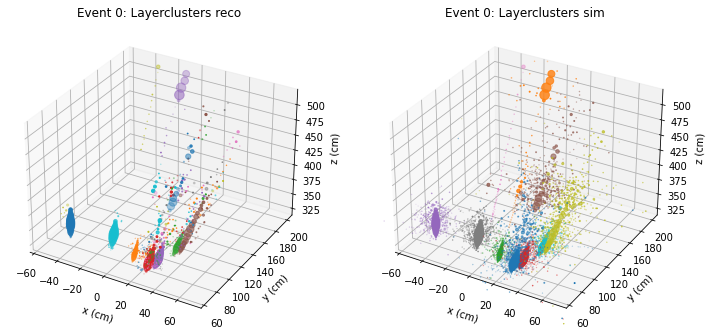

In [7]:
eid = 0
plot_event(tracksters, simtracksters, eid, legend=False)
print("SimTracksters:", simtracksters["stsSC_NTracksters"].array()[eid])
print("RecoTracksters:", tracksters["NTracksters"].array()[eid])

### Association scores
- 1 means completely unmatched
- 0 means a perfect 

The idea is to use argmax over the scores and then get the index of the best matched trackster

In [8]:
r2si = associations["tsCLUE3D_recoToSim_SC"].array()[eid]
r2s = associations["tsCLUE3D_recoToSim_SC_score"].array()[eid] # [tracksters] -> [simtracksters]

s2ri = associations["tsCLUE3D_simToReco_SC"].array()[eid]
s2r = associations["tsCLUE3D_simToReco_SC_score"].array()[eid] # [simtracksters] -> [tracksters]

print("Reco to sim:", r2s)
print("Reco to sim indexes:", r2si)

print("Sim to reco:", s2r)
print("Sim to reco indexes:", s2ri)

Reco to sim: [[1, 1, 1, 1, 1, 1, 1, 1, 0.999, 0.00042, ... 1, 1, 1, 1, 1, 1, 1, 0.994, 0.00156]]
Reco to sim indexes: [[1, 2, 4, 5, 6, 7, 8, 9, 3, 0], [1, 4, 5, ... 9, 5], [0, 2, 3, 4, 7, 9, 8, 5, 1, 6]]
Sim to reco: [[0.0491, 0.982, 0.999, 0.999, 1, 1, 0.997, 0.999, ... 1, 1, 1, 1, 1, 1, 1, 1]]
Sim to reco indexes: [[3, 39, 26, 12, 11, 6, 27, 47, 38, 20, ... 25, 26, 27, 28, 29, 30, 31, 32, 33, 0]]


### Training set categories:
- **perfect match**
    - same number of sim and reco tracksters
    - only one matched trackster below a threshold
- **mix-up** (skip for now)
    - same number of sim and reco tracksters
    - multiple matched tracksters below a threshold
    - should be split and reclustered?
- **overmerged** (skip for now)
    - more sim tracksters than reco tracksters
    - should be split
- **split**
    - more reco tracksters than sim tracksters
    - multiple well matched tracksters
    - should be joined

In [9]:
perfect_eids, split_eids = get_eid_splits(tracksters, simtracksters, associations)

Perfect events: []
Split events: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


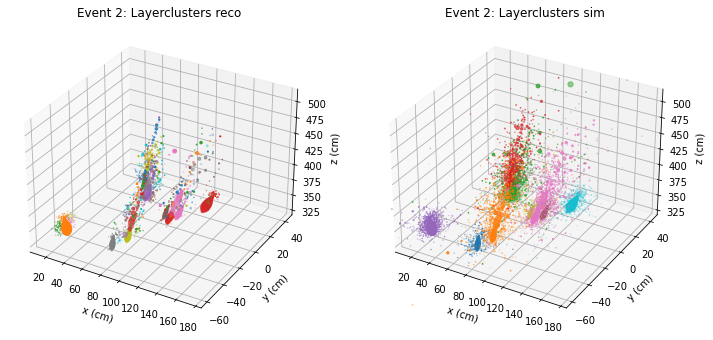

In [10]:
print("Perfect events:", perfect_eids)
print("Split events:", split_eids)

if perfect_eids:
    plot_event(tracksters, simtracksters, perfect_eids[0], legend=False)

plot_event(tracksters, simtracksters, split_eids[2], legend=False)

### Incomplete trackster identification

Not all tracksters in a split event are incomplete.
- Try to identify the most mismatched tracksters
- We even know how many they should be

Incomplete trackster candidates
- use fractions simToReco shared energy (fraction shared to total)
- tracksters with the smallest fraction are probably the ones we need to merge in
- TODO: get histograms of these fractions (to test the separation)

Total reco tracksters: 1895, complete: 123, Incomplete: 1695


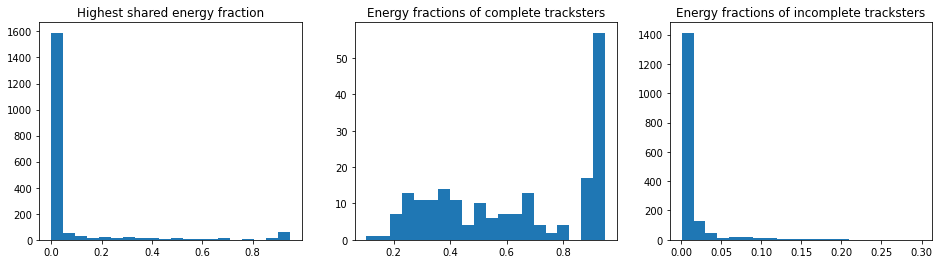

In [11]:
h_frac = {eid:get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid) for eid in split_eids}

complete_tracksters, incomplete_tracksters = split_on_shared_energy(
    tracksters,
    simtracksters,
    h_frac,
    split_eids,
    histogram=True
)

### Inspect the results

Event 0: complete: [25, 3, 68, 64, 2, 4, 1, 10, 9] incomplete : [31, 28, 32, 53, 7, 48, 8, 56, 0, 13, 55, 14, 15, 5, 17, 63, 40, 21, 20, 22, 59, 46, 62, 67, 54, 38, 41, 47, 61, 27, 50, 49, 23, 58, 16, 6, 37, 11, 18, 33, 52, 42, 51, 29, 34, 12, 26, 24, 66, 45, 65, 44, 57, 35, 36, 43, 39, 19, 60]
Event 1: complete: [5, 77, 10, 7, 4, 6] incomplete : [19, 59, 11, 52, 71, 75, 20, 0, 40, 49, 8, 42, 44, 62, 3, 28, 48, 67, 13, 56, 35, 29, 47, 23, 50, 53, 60, 31, 9, 66, 17, 14, 21, 24, 63, 38, 72, 33, 30, 26, 46, 39, 37, 15, 22, 41, 61, 36, 65, 73, 70, 51, 76, 74, 34, 54, 16, 57, 64, 27, 69, 45, 55, 2, 43, 68, 18, 58]


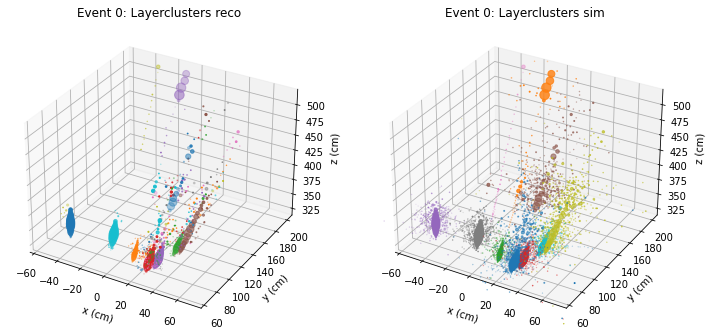

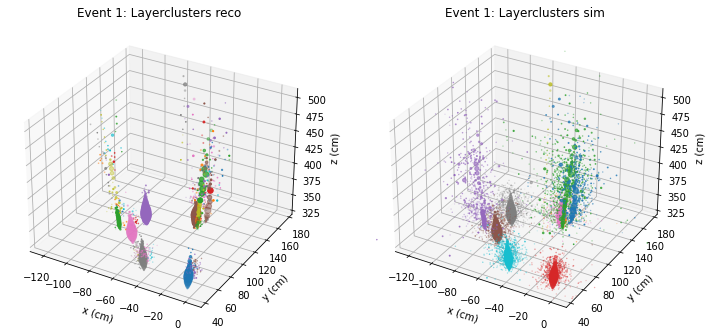

In [12]:
for i, (eid, it) in enumerate(incomplete_tracksters[:2]):
    print(f"Event {eid}: complete: {complete_tracksters[i][1]} incomplete : {it}")
    plot_event(tracksters, simtracksters, eid, legend=False)

In [ ]:
vertices_x = []
vertices_y = []
vertices_z = []
vertices_energy = []
vertices_indexes = []
trackster_label = []
trackster_event = []

datafiles = [
    f"new_ntuples_14132277_{x}.root" for x in range(900, 950)
]

datadir = "~/data/multiparticle"

for datafile in datafiles:
    print("Processing file:", datafile)
    filepath = f"{datadir}/{datafile}"
    try:
        tracksters = uproot.open({filepath: "ticlNtuplizer/tracksters"})
        simtracksters = uproot.open({filepath: "ticlNtuplizer/simtrackstersSC"})
        associations = uproot.open({filepath: "ticlNtuplizer/associations"})
    except:
        print("file not found:", datafile)
        continue

    # categorize events into perfect and split
    perfect_eids, split_eids = get_eid_splits(tracksters, simtracksters, associations)

    # get the perfect tracksters
    perfect_tracksters = unfold_tracksters(tracksters, perfect_eids)

    # get highest energy simtracksters for each split eids
    h_frac = {
        eid:get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid)
        for eid in split_eids
    }

    # get the complete and incomplete tracksters from split events
    complete_tracksters, incomplete_tracksters = split_on_shared_energy(
        tracksters,
        simtracksters,
        h_frac,
        split_eids
    )

    # assign labels to trackster sets
    set_labels = (
        (incomplete_tracksters, 0),
        (complete_tracksters, 1),
        (perfect_tracksters, 1),
    )

    vx = tracksters["vertices_x"].array()
    vy = tracksters["vertices_y"].array()
    vz = tracksters["vertices_z"].array()
    ve = tracksters["vertices_energy"].array()
    vi = tracksters["vertices_indexes"].array()

    for tset, label in set_labels:
        for eid, tids in tset:
            for tid in tids:
                vertices_x.append(vx[eid][tid])
                vertices_y.append(vy[eid][tid])
                vertices_z.append(vz[eid][tid])
                vertices_energy.append(ve[eid][tid])
                vertices_indexes.append(vi[eid][tid])
                trackster_label.append(label)
                trackster_event.append(eid)

In [21]:
ds = uproot.recreate("data/trackster_tags_1ke_multi.root")
ds["tracksters"] = {
    "vertices_x": vertices_x,
    "vertices_y": vertices_y,
    "vertices_z": vertices_z,
    "vertices_energy": vertices_energy,
    "vertices_indexes": vertices_indexes,
    "trackster_label": trackster_label,
    "trackster_event": trackster_event,
}
ds.close()